In [4]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from pathlib import Path

# Path to your facility summary CSV file
file_path = "../data/raw/2021_NEI_Facility_summary.csv"  

print(f"Reading data from {file_path}...")

# Create output directory if it doesn't exist
output_dir = Path("../data/processed")
output_dir.mkdir(parents=True, exist_ok=True)

# Read the CSV file - automatically detect the delimiter
try:
    df = pd.read_csv(file_path, sep=',', low_memory=False)
    print("File read with tab delimiter")
except:
    try:
        df = pd.read_csv(file_path, low_memory=False)
        print("File read with comma delimiter")
    except:
        df = pd.read_csv(file_path, sep=None, engine='python', low_memory=False)
        print(f"File read with automatic delimiter detection")

print(f"Data loaded. Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

Reading data from ../data/raw/2021_NEI_Facility_summary.csv...
File read with tab delimiter
Data loaded. Shape: (2005169, 33)
Columns: ['state', 'fips state code', 'tribal name', 'fips code', 'county', 'eis facility id', 'program system code', 'agency facility id', 'tri facility id', 'company name', 'site name', 'primary naics code', 'primary naics description', 'facility source type', 'site latitude', 'site longitude', 'address', 'city', 'zip code', 'postal abbreviation', 'reporting period', 'emissions operating type', 'pollutant code', 'pollutant desc', 'pollutant type(s)', 'hap type', 'total emissions', 'emissions uom', 'data set', 'outlier minimum', 'outlier maximum', 'outlier?', 'national maximum']


In [26]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# ================================
# Step 1: Load & Process Emissions Data
# ================================

print("Aggregating emissions by facility and pollutant category...")

# Ensure latitude and longitude exist before creating geometry
df['geometry'] = df.apply(lambda row: Point(row['site longitude'], row['site latitude']), axis=1)

# Convert emissions to metric tonnes
def convert_to_tonnes(row):
    if row['emissions uom'] == 'LB':
        return float(row['total emissions']) * 0.000453592  # Convert pounds to metric tonnes
    elif row['emissions uom'] == 'TON':
        return float(row['total emissions']) * 0.90718474  # Convert short tons to metric tonnes
    return float(row['total emissions'])  # Already in metric tonnes

df['emissions_tonnes'] = df.apply(convert_to_tonnes, axis=1)

# Categorize pollutants
def categorize_pollutant(row):
    pollutant = str(row['pollutant code']).upper()
    pollutant_desc = str(row['pollutant desc']).upper()

    if pollutant == 'VOC' or 'VOLATILE ORGANIC' in pollutant_desc:
        return 'VOC'
    elif pollutant in ['NOX', 'NO', 'NO2'] or ('NITROGEN' in pollutant_desc and 'OXIDE' in pollutant_desc):
        return 'NOx'
    elif pollutant == 'NH3' or 'AMMONIA' in pollutant_desc:
        return 'NH3'
    elif pollutant in ['SO2', 'SO4'] or 'SULFUR' in pollutant_desc:
        return 'SOx'
    elif 'PM25' in pollutant or 'PM2.5' in pollutant_desc or 'PM2_5' in pollutant:
        return 'PM2_5'
    return 'Other'

df['pollutant_category'] = df.apply(categorize_pollutant, axis=1)

# Filter out Alaska & Hawaii
df = df[~df['state'].isin(['AK', 'HI'])]

# ================================
# Step 2: Aggregate Data by Facility
# ================================

facility_emissions = df.groupby([
    'eis facility id', 'site name', 'state', 'site latitude', 'site longitude', 
    'primary naics code', 'primary naics description', 'pollutant_category'
])['emissions_tonnes'].sum().reset_index()

# Convert to wide format with pollutants as columns
facility_wide = facility_emissions.pivot_table(
    index=['eis facility id', 'site name', 'state', 'site latitude', 'site longitude', 
           'primary naics code', 'primary naics description'],
    columns='pollutant_category', 
    values='emissions_tonnes',
    fill_value=0
).reset_index()

# Ensure all required pollutant columns exist
for cat in ['VOC', 'NOx', 'NH3', 'SOx', 'PM2_5']:
    if cat not in facility_wide.columns:
        facility_wide[cat] = 0

# ================================
# Step 3: Create GeoDataFrame & Filter Power Plants
# ================================

print("Creating GeoDataFrame...")
facility_wide['geometry'] = facility_wide.apply(lambda row: Point(row['site longitude'], row['site latitude']), axis=1)

gdf = gpd.GeoDataFrame(
    facility_wide, 
    geometry='geometry',
    crs='epsg:4269'  # Set coordinate reference system
)

# Filter for power plants (EGUs) using NAICS codes
egu_naics = ['2211', '221111', '221112', '221113', '221114', '221115', '221116', '221117', '221118']
egu_gdf = gdf[gdf['primary naics code'].astype(str).str.startswith(tuple(egu_naics))]

print(f"Found {len(egu_gdf)} power plant facilities (in the lower 48 states)")

# ================================
# Step 4: Save Processed Data
# ================================

output_dir = "../data/processed"  # Change this to your output folder

egu_output_file = f"{output_dir}/processed_2022_egu_emissions.gpkg"
egu_gdf.to_file(egu_output_file, driver="GPKG")
print(f"Saved processed power plant data to {egu_output_file}")

# Save all facilities data
all_facilities_output = f"{output_dir}/processed_2022_all_facilities_emissions.gpkg"
gdf.to_file(all_facilities_output, driver="GPKG")
print(f"Saved all facilities data to {all_facilities_output}")

# ================================
# Step 5: Generate Industry Summary
# ================================

print("\nGenerating summary by industry type...")

industry_summary = gdf.groupby('primary naics description').agg({
    'VOC': 'sum',
    'NOx': 'sum',
    'NH3': 'sum',
    'SOx': 'sum',
    'PM2_5': 'sum',
    'eis facility id': 'count'
}).reset_index()

industry_summary = industry_summary.rename(columns={'eis facility id': 'facility_count'})
industry_summary = industry_summary.sort_values('NOx', ascending=False)

# Save industry summary to CSV
industry_summary_file = f"{output_dir}/industry_emissions_summary.csv"
industry_summary.to_csv(industry_summary_file, index=False)
print(f"Saved industry summary to {industry_summary_file}")

print("\nProcessing complete!")


Aggregating emissions by facility and pollutant category...
Creating GeoDataFrame...
Found 2628 power plant facilities (in the lower 48 states)
Saved processed power plant data to ../data/processed/processed_2022_egu_emissions.gpkg
Saved all facilities data to ../data/processed/processed_2022_all_facilities_emissions.gpkg

Generating summary by industry type...
Saved industry summary to ../data/processed/industry_emissions_summary.csv

Processing complete!


In [27]:
egu_gdf

pollutant_category,eis facility id,site name,state,site latitude,site longitude,primary naics code,primary naics description,NH3,NOx,Other,PM2_5,SOx,VOC,geometry
89,17611,"MRP SAN JOAQUIN ENERGY, LLC",CA,36.270400,-119.647400,221118,Other Electric Power Generation,0.441733,0.641244,4686.430675,0.470519,0.042937,0.055589,POINT (-119.6474 36.2704)
200,53211,MT. LASSEN POWER,CA,40.297000,-121.018000,221122,Electric Power Distribution,11.811545,76.203518,57.150546,47.876538,4.941417,0.358020,POINT (-121.018 40.297)
204,66511,MM WEST COVINA LLC,CA,34.033443,-117.906284,221112,Fossil Fuel Electric Power Generation,2.906438,7.919723,5.602850,5.817317,0.204557,1.337726,POINT (-117.90628 34.03344)
225,75711,WADHAM ENERGY LTD PARTNERSHIP,CA,39.105500,-122.110400,221118,Other Electric Power Generation,0.000000,119.261319,147.282527,35.579995,61.742192,0.539852,POINT (-122.1104 39.1055)
229,76811,MORNING STAR PACKING COMPANY,CA,39.126400,-122.125100,221118,Other Electric Power Generation,0.000000,15.260778,128801.547243,16.170375,1.253362,5.155173,POINT (-122.1251 39.1264)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82485,21432511,LAPORTE GENERATING STATION,TX,29.703067,-95.071903,221112,Fossil Fuel Electric Power Generation,0.000000,17.470564,10.635674,3.393462,0.140135,0.036015,POINT (-95.0719 29.70307)
82486,21432611,HO CLARKE GENERATING,TX,29.646389,-95.451667,221112,Fossil Fuel Electric Power Generation,0.825538,84.114169,155582.309712,37.597025,1.967734,6.359365,POINT (-95.45167 29.64639)
82568,21452511,"Generate Fremont Digester, LLC",MI,43.459500,-85.976200,221117,Biomass Electric Power Generation,0.000000,4.935085,32.157340,1.196784,11.019753,0.151591,POINT (-85.9762 43.4595)
82659,21469011,City of Lehi Power Plant,UT,40.392696,-111.859829,221112,Fossil Fuel Electric Power Generation,0.000000,0.439287,1.508112,0.706428,0.036562,0.782882,POINT (-111.85983 40.3927)


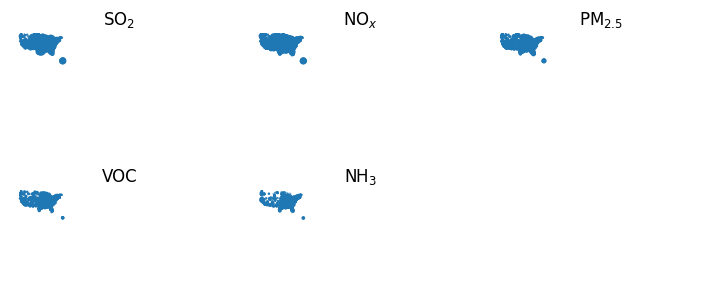

In [14]:
# Finally, let's make some maps of the emissions.

import matplotlib.pyplot as plt
%matplotlib inline

pols = ["SOx", "NOx", "PM2_5", "VOC", "NH3"]
pol_names = ["SO$_2$", "NO$_x$", "PM$_{2.5}$", "VOC", "NH$_3$"]

fig, axes = plt.subplots(figsize=(7, 3), nrows=2, ncols=3, sharex=True, sharey=True)
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.1, hspace=0.1)

i = 0
for x in axes:
    for ax in x:
        if i < len(pols):
            egu_gdf.plot(ax=ax, markersize=egu_gdf[pols[i]]**0.5 / 5)  # Use egu_gdf instead of emis
            ax.set_title(pol_names[i])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')
        i = i + 1
plt.show()

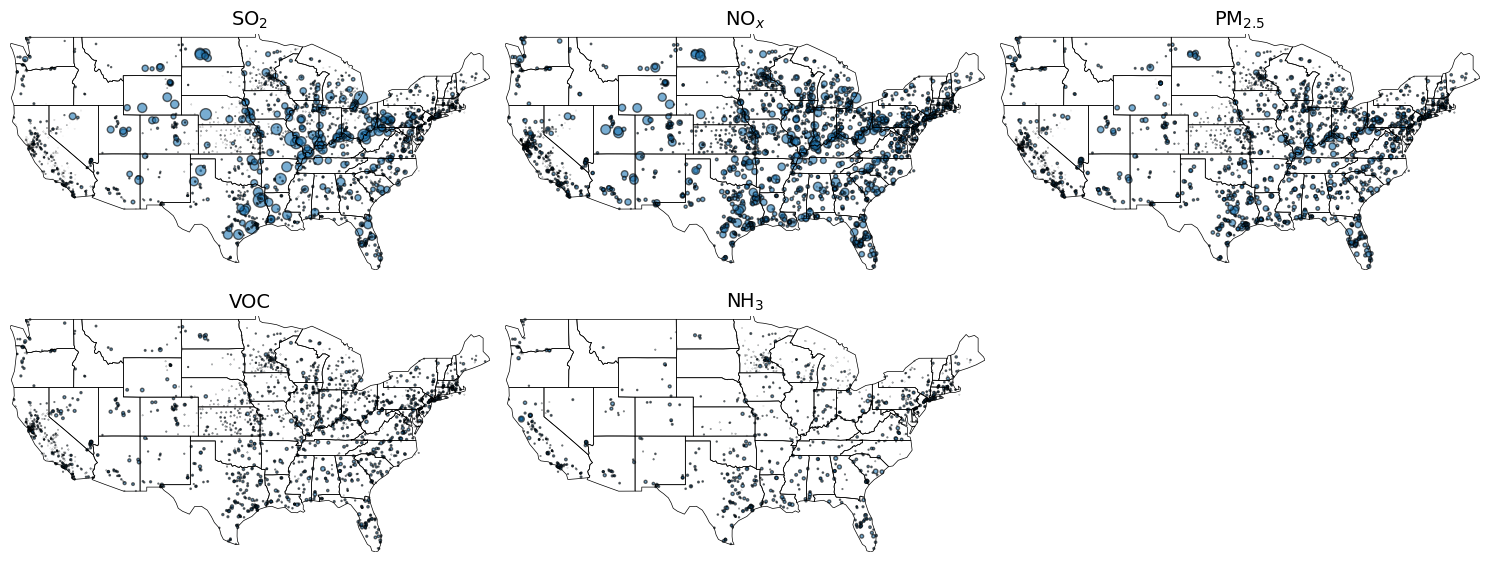

In [42]:
import matplotlib.pyplot as plt
import geopandas as gpd
%matplotlib inline

# 1. Load & Convert CRS
us_states = gpd.read_file("../data/raw/ne_110m_admin_1_states_provinces/ne_110m_admin_1_states_provinces.shp")
us_states = us_states[~us_states['name'].isin(['Alaska', 'Hawaii'])]
us_states = us_states.to_crs(epsg=4269)  # match egu_gdf if egu_gdf is in EPSG:4269

egu_gdf = egu_gdf.to_crs(epsg=4269)     # ensure egu_gdf also in EPSG:4269

# 2. Pollutants
pols = ["SOx", "NOx", "PM2_5", "VOC", "NH3"]
pol_names = ["SO$_2$", "NO$_x$", "PM$_{2.5}$", "VOC", "NH$_3$"]

# 3. Plot
fig, axes = plt.subplots(figsize=(15, 6), nrows=2, ncols=3, sharex=True, sharey=True)
#plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.01, hspace=0.01)

minx, miny, maxx, maxy = us_states.total_bounds

for i, ax in enumerate(axes.flat):
    if i < len(pols):
        us_states.boundary.plot(ax=ax, color="black", linewidth=0.5)
        egu_gdf.plot(
            ax=ax,
            markersize=egu_gdf[pols[i]]**0.5 / 2,
            alpha=0.6,
            edgecolor='black'
        )
        ax.set_title(pol_names[i], fontsize=14)
        
        # Zoom to lower 48
        ax.set_xlim(minx, maxx)
        ax.set_ylim(miny, maxy)
        
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')

# 4. Remove the last unused subplot
fig.delaxes(axes[1, 2])
plt.tight_layout()
plt.show()